In [1]:
import os

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import tensorflow._api.v2.compat.v1 as tf
import sklearn
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from scipy import signal

from models import deeper_fcn as architecture
from scipy.fft import fft, fftfreq
import algorithms.heartrate as hr
import algorithms.movement_detection as md
import algorithms.common as cm
import algorithms.segmenter as sg
import utils
from algorithms.FFT import FFT as FFT
from datetime import timedelta

2023-03-06 00:23:52.065242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_14782/3419770438.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [2]:
# tensorflow settings
tf.logging.set_verbosity(tf.logging.ERROR)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

(512,)
[54 58 62]
(774, 400)
2353324


ValueError: cannot reshape array of size 2353324 into shape (147082,16)

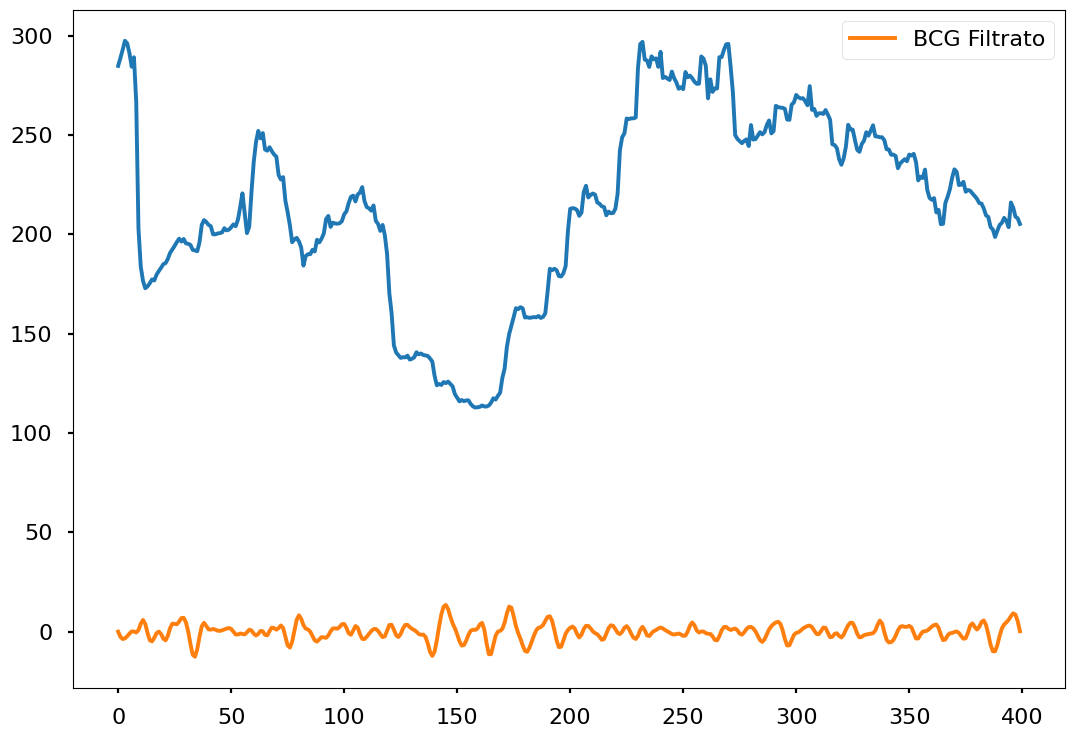

In [3]:
# load data
# x_data_train, y_data_train, groups_train = ...
# dummy:
#data_folder = 'data'

train_size = 774
n_groups = 28
data = np.genfromtxt('data/raw_2022-03-14_bcg.csv', delimiter=';')
# print the shape of the data
#print(data.shape)

movsign=md.detect_movements(data[:512],50)

normalizzato=sg.renormalize_signal(data[:400],50)

filtered=cm.filter_bandpass(normalizzato,50,2,10)
filtered2=cm.filter_bandpass(data[:400],50,2,10)

print(movsign.shape)
plt.plot(normalizzato)
plt.plot(filtered2, label='BCG Filtrato')
plt.legend()
'''
plt.plot(movsign, label='movimento')
plt.legend()
plt.xlabel("Tempo[s]")
plt.ylabel("Ampiezza")
plt.show()
'''
hearths=hr.get_heartrate_pipe(filtered)
indicesijk=sg.find_ijk(filtered,50,[-1,-1,1])
print(indicesijk)
'''

#FOURIER TRANSFORM (DFT)

# Number of sample points
N = 500
# sample spacing
T = 1.0 / 50.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = filtered
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.stem(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frequenza[Hz]")
plt.ylabel("Ampiezza")
plt.show()
'''
data = data[:len(data)-len(data)%400]
# reshape the data to be 2D array with 400 columns and 5 rows   (400, 5)

data = data.reshape( int(len(data)/400), 400)
# print the shape of the data
print(data.shape)

x_data_train = np.expand_dims(data, axis=2)

#y_train section
data = np.genfromtxt('data/experiments/gold.csv', delimiter=',')
print(len(data))
y_data_train = np.mean(data.reshape(int(len(data)/16), 16), axis=1)
y_data_train2=signal.resample(y_data_train,round(len(y_data_train)/2))


# compute average each 8 elements in the array
data = data[:len(data)-len(data)%16]
y_data_train = np.mean(data.reshape(int(len(data)/16), 16), axis=1)
y_data_train2=signal.resample(y_data_train,round(len(y_data_train)/2))
y_data_train = y_data_train[:774]
y= np.arange(0,400,1)

xmax = y[np.argmax(y_data_train2)]
ymax = y_data_train2.max()


#xposmin = np.where(y_data_train2==min)
#xmin = y[xposmin]
print(xmax)
print(ymax)
#y_timedelta = [str(timedelta(seconds=int(s))) for s in y]
#plt.plot(max,'o')
#plt.plot(min,'o')

#plt.plot(y_data_train[:400], label='gold')
#plt.xticks(y_data_train2[:400],y_timedelta)
plt.xlabel("Numero campioni ")
plt.ylabel("Magnitudo")
#plt.plot(y_data_train2[:100], label='y_train2')
#plt.plot(xmax,ymax,'X')
#plt.plot(xmin,ymin,'X')
print("zeros",len(y_data_train) - np.count_nonzero(y_data_train))
print(y_data_train.shape)
# print first 2 rows of the data
groups_train = np.sort(np.random.randint(n_groups, size=train_size))

print(x_data_train.shape, y_data_train.shape, groups_train.shape)

# print(x_data_train[0,:50])
# plot x_data_train

#plt.plot(x_data_train[:400], label='x_data_train')
# plt.plot(y_data_train[:50], label='y_data_train')
#plt.legend()

plt.show()



In [4]:
enlarge = 1
model_params = dict(metrics=["mae", "mape"], enlarge=enlarge)
fit_params = dict(epochs=30, verbose=2)  # set epochs between 30 and 75

modelname = (architecture.__name__ + "-x{}".format(enlarge))
modelpath = os.path.join("output", modelname)
os.makedirs(os.path.join(modelpath, "final"), exist_ok=True)
print(modelpath)

# write model architecture to JSON file
model = architecture.create(**model_params)
with open(os.path.join(modelpath, "model.json"), "w") as fp:
    fp.write(model.to_json())

output/models.deeper_fcn-x1


In [5]:
# single process for parallel training
def process_split(xt, yt, i, fit_params):
    # set allow_growth in subprocess
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.keras.backend.set_session(tf.Session(config=config))
    
    csv_path = os.path.join(modelpath, "logs-{:02d}.csv".format(i))
    weights_path = os.path.join(modelpath, "weights-{:02d}.h5".format(i))
    fit_params.update(callbacks=[tf.keras.callbacks.CSVLogger(csv_path)])
    
    model = architecture.create(**model_params)
    r = model.fit(xt, yt, **fit_params)
    
    model.save_weights(weights_path)
    tf.keras.backend.clear_session()

    return r.history

In [6]:
# split training data with LeaveOneGroupOut cross validation
splitter = utils.get_group_splitter(n_groups, groups_train)

NameError: name 'groups_train' is not defined

In [ ]:
rs = Parallel(n_jobs=4, verbose=10)(
    delayed(process_split)(x_data_train[t_inds], y_data_train[t_inds],
                           i, fit_params)
    for i, (t_inds, v_inds) in enumerate(splitter)
)

In [ ]:
model = utils.get_model_from_json(modelpath, "model.json")

# calculate MAPE and MAE for each left-out patient
splitter = LeaveOneGroupOut().split(x_data_train, y_data_train, groups=groups_train)
results = []
for i, (t_inds, v_inds) in enumerate(splitter):
    model.load_weights(os.path.join(modelpath, "weights-{:02d}.h5".format(i)))
    y_pred = model.predict(x_data_train[v_inds])
    y_true = y_data_train[v_inds]
    results.append((hr.hr_mape(y_true, y_pred), hr.hr_mae(y_true, y_pred)))
results = np.array(results)
display(results)

In [1]:
# train one model on entire training set

model = architecture.create(**model_params)
r = model.fit(x_data_train, y_data_train, **fit_params)
model.save_weights(os.path.join(modelpath, "final", "weights-00.h5"))
tf.keras.backend.clear_session()

NameError: name 'architecture' is not defined